# Hybrid Control Car

This project will demonstrated a hybrid machine learning and optimal control theory approach to controlling a simulated racecar. A neural network - which will henceforce be referred to as the pathfinding network - will be trained using reinforcement learning to pathfind, selecting the position of and the desired velocity of the car at the next path node based on sensor readings and the current state of the car. An inner control loop will use model predictive control with LQR feedback to drive the car to the next node.

The underlying physics simulation is written in the Rust programming language using [Rapier](https://rapier.rs/) as the physics engine with Python bindings generated by [PyO3](https://pyo3.rs). Its source code is avaiable at [src/lib.rs](src/lib.rs).

We will first start by importing the necessary libraries and establishing a few parameters.

In [1]:
from hybrid_control_car import CarSimulation # The simulation developed for this project
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pysindy

nstates = 5 # The number of state variables (x, z, v, n_x, n_z)
ninputs = 2 # The number of inputs (F_e, phi)

# 1 Deriving a Model of the Car

While an accurate model of the car itself could be derived mathematically, for the purposes of this project we will not attempt to do so, treating the car as a standing for a far more complex system. To that end, we will use Sparse Indentification of Nonlinear Dynamics (SINDy) to create a model of the system computationally using the pySINDy library. This algorithm was chosen for several reasons:

1. It may be difficult to linearize about an equilibrium point while still maintaining a high level of accuracy.
2. pySINDy allows for finding the nonlinear dynamics using multiple trajectories of test data.
3. []

A model with at least 75% accuracy for the first few seconds is desired. Later on, feedback control will be used to compensate for any inaccuracies in the model, so a near-perfect model is not necessary, but we will aim to create one anyways.

## 1.1 Simulation and Analysis

Selecting the state and input vectors requires balancing adequet representation of the system and control in the inner MPC controller loop with the complexity of the model. A model with more states specifically will require the pathfinding network to determine more states for the next node and will make it more difficult to fit the SINDy model with accuracy. With these considerations, the following state and input vectors have been selected.

$$
\vec{x} = \begin{bmatrix} x \\ z \\ v \\ n_x \\ n_z \end{bmatrix}, \vec{u} = \begin{bmatrix} \theta \\ F_e \end{bmatrix}
$$

Where $x$ and $z$ are the position of the car along those axis, $v$ is the forward velocity scalar of the car, $n_x$ and $n_z$ are the unit vector components in the forward direction of the car in the $xz$ plane, $\theta$ is the steering angle of the car, and $F_e$ is the force exerted by the engine. While the angular velocity about the y-axis could be considered, it seems like it would add more complexity to the model for very little gain.

In terms of units, we will define one second as equivalent to 60 simulation timesteps. Since $x$ and $z$ are returned in units and $v$ is returned in units per timestep, we will define one meter as equivalent to 60 units, otherwise we will get very large velocities and distances.

Training data will be generated by holding both inputs steady at multiple different values, holding one steady while one is changes, and by having both change; Testing data will be generated in the same way.

In [2]:
def compute_phi(n_x, n_z) -> float:
    phi = 0.0
    
    if n_z == 0:
        if n_x == -1.0: phi = np.pi
    elif n_x == 0.0:
        if n_z == 1.0: phi = np.pi/2.0
        else: phi = 3*np.pi/2.0
    else:
        phi = np.arctan2(n_z, n_x)

    return phi

In [3]:
# Set up the simulation
sim = CarSimulation()
sim.create_floor()

hz = 60 # Timesteps per second
upm = 60 # Units per meter

def simulate(sim: CarSimulation, engine_force: float, steering_angle: float):
    # Convert force to kg*units/timestep^2
    engine_force = engine_force*(hz/upm**2)

    state, colliding, checkpoint, finish = sim.step(engine_force, steering_angle)
    state = np.array(state)
    # Convert units
    state[0] = state[0]/upm # x
    state[1] = state[1]/upm # z
    state[2] = state[2]*(hz/upm) # v

    return state, colliding, checkpoint, finish

def generate_training_data(sim: CarSimulation, rotation: float, nsamples, nstates, inputs):
    sim.reset_car(rotation)

    data = np.zeros((nsamples, nstates))
    # x, z, v, n_x, n_z
    x0 = np.array([0.0, 0.0, 0.0, np.cos(rotation), np.sin(rotation)])

    for n in range(nsamples):
        engine_force = inputs[n, 0]
        steering_angle = inputs[n, 1]
        state, _, _, _ = simulate(sim, engine_force, steering_angle)
        data[n, :] = x0
        x0 = state

    return data

nsteps_samples = hz*20 # 10 seconds worth of sample data
all_sample_states = []
all_sample_inputs = []

rotations = np.linspace(0, 2*np.pi, 8)
Fe_samples = [
    300 * np.ones(nsteps_samples),
    600 * np.ones(nsteps_samples),
    900 * np.ones(nsteps_samples),
    1500 * np.ones(nsteps_samples),
    np.linspace(0, 600, nsteps_samples),
    np.linspace(600, 0, nsteps_samples),
    np.linspace(-600, 600, nsteps_samples),
    np.linspace(600, -600, nsteps_samples),
    np.concatenate(
        (
            np.linspace(0, 900, int(nsteps_samples/4)),
            900*np.ones(3*(int(nsteps_samples/4)))
        )
    ),
    np.concatenate(
        (
            np.linspace(0, -900, int(nsteps_samples/4)),
            -900*np.ones(3*(int(nsteps_samples/4)))
        )
    ),
]
Theta_samples = [
    0 * np.ones(nsteps_samples),
    0.35*np.ones(nsteps_samples),
    -0.35*np.ones(nsteps_samples),
    np.concatenate(
        (
            0.35*np.ones(int(nsteps_samples/4)),
            np.zeros(3*(int(nsteps_samples/4)))
        )
    ),
    np.concatenate(
        (
            -0.35*np.ones(int(nsteps_samples/4)),
            np.zeros(3*(int(nsteps_samples/4)))
        )
    ),
    np.linspace(0, 0.35, nsteps_samples),
    np.linspace(0, -0.35, nsteps_samples),
    np.linspace(0.1, -0.1, nsteps_samples),
    np.linspace(-0.1, 0.1, nsteps_samples)
]

for i in range(len(rotations)):
    for j in range(len(Fe_samples)):
        for k in range(len(Theta_samples)):
            rotation = rotations[i]
            Fe = Fe_samples[j]
            theta = Theta_samples[k]
            inputs = np.array([Fe, theta]).T
            state = generate_training_data(sim, rotation, nsteps_samples, nstates, inputs)

            all_sample_states.append(state)
            all_sample_inputs.append(inputs)

print(f"Generated a total of {len(all_sample_states)} sample trajectories.")


Generated a total of 720 sample trajectories.


To visualize the system dynamics, lets plot some of the test data for analysis, starting with the very first trajectory.

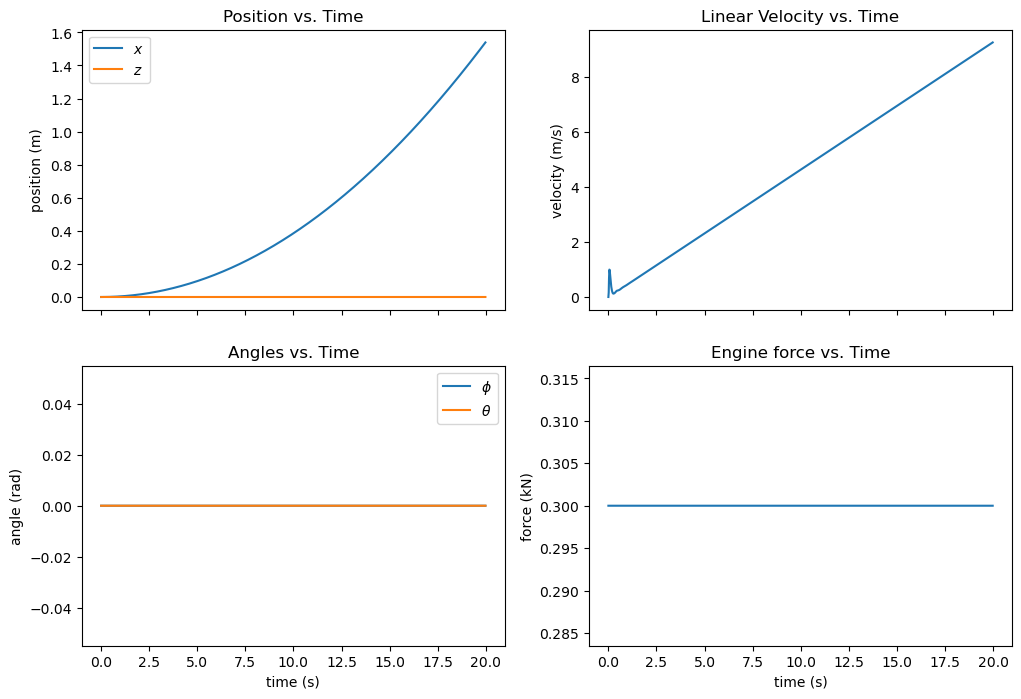

In [4]:
def plot_data(t, state, input):
    x = state[:, 0]
    z = state[:, 1]
    v = state[:, 2]
    phi = np.arctan2(state[:, 4], state[:, 3])
    Fe = input[:, 0]
    Fe = Fe/1000 # Convert to kN
    theta = input[:, 1]

    fig, axs = plt.subplots(2, 2, sharex=True, figsize = (12, 8))
    axs = axs.flatten()

    axs[0].plot(t, x, label='$x$')
    axs[0].plot(t, z, label='$z$')
    axs[0].set_title("Position vs. Time")
    axs[0].set_ylabel("position (m)")
    axs[0].legend()

    axs[1].plot(t, v)
    axs[1].set_title("Linear Velocity vs. Time")
    axs[1].set_ylabel("velocity (m/s)")

    axs[2].plot(t, phi, label=r'$\phi$')
    axs[2].plot(t, theta, label=r"$\theta$")
    axs[2].set_title("Angles vs. Time")
    axs[2].set_xlabel("time (s)")
    axs[2].set_ylabel("angle (rad)")
    axs[2].legend()

    axs[3].plot(t, Fe)
    axs[3].set_title("Engine force vs. Time")
    axs[3].set_xlabel("time (s)")
    axs[3].set_ylabel("force (kN)")

tseconds = np.linspace(0, nsteps_samples - 1, nsteps_samples)/hz

plot_data(tseconds, all_sample_states[0], all_sample_inputs[0])

plt.show()

As expected, holding the engine force steady results in an increasing forward velocity and position, with the position increasing exponentially. What's not expected is the car being rotated slightly, likely a floating point error. I attempted to fix this by adjusting the height the car is created at in the simulation code to no avail.

Let's plot a later data set and see if there are more interesting results.

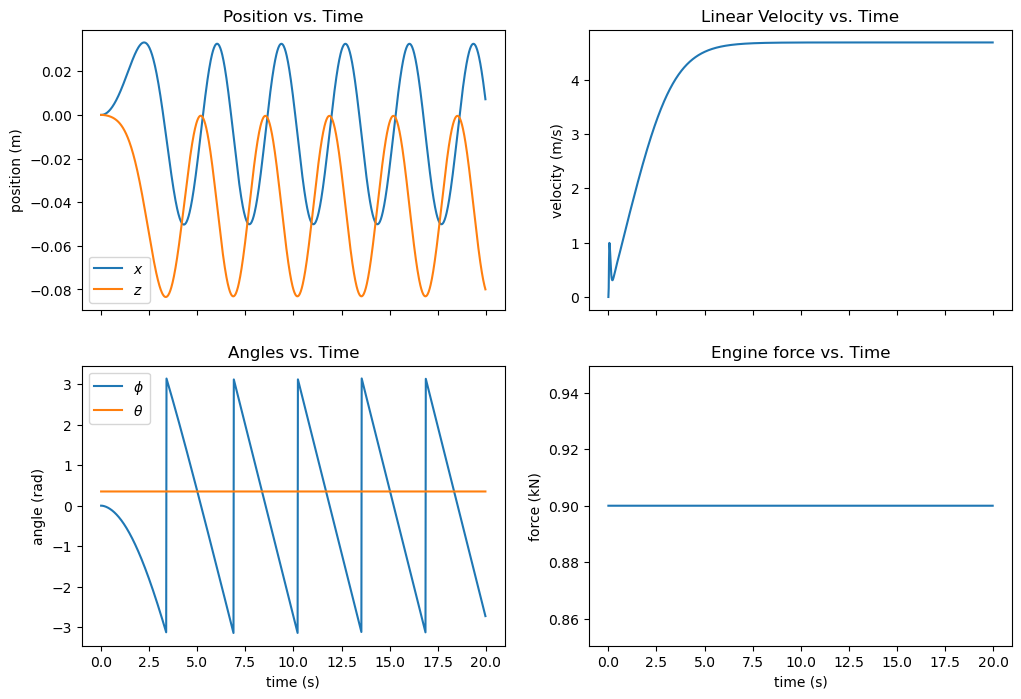

In [5]:
plot_data(tseconds, all_sample_states[19], all_sample_inputs[19])

A higher engine force to start with naturally leads to faster oscillations in the position and velocity responses. Now, let's make one final plot.

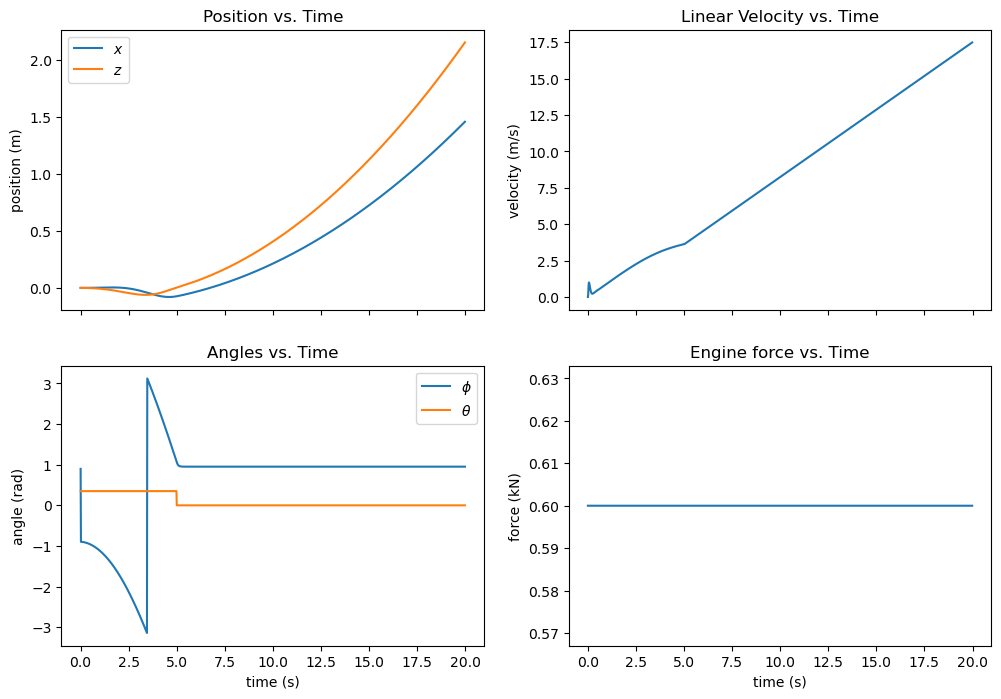

In [6]:
plot_data(tseconds, all_sample_states[102], all_sample_inputs[102])

It is interesting how holding the engine force steady while changing the steering angle leads to oscillations in the state responses becoming a higher frequency.

## 1.2 Modeling with pySINDy

This data will now be used to fit a SINDy model; 

Fortunately, the pySINDy Github repo provides a handy flowchart for choosing the right function library/libraries and optimizer for fitting the SINDy model to the measurement/test data.

![foo](https://raw.githubusercontent.com/dynamicslab/pysindy/master/docs/JOSS2/Fig3.png)

Since we are not solving for an implicit ODE (as far as I'm aware), the data has control inputs, is not spatially dependent and does not have significant noise, the flowchart says to use any pySINDy library. Since there are no inequality constraints in the system (as far as I'm aware), we can also use any pySINDy optimizer.

The default library is the `PolynomialLibrary`, which contains a variety of polynomial functions (to the second degree by default). PySINDy also provides a `CustomLibrary`, which will allow us to insert our own functions - we will use this to create a feature library with `sin` and `cos`, then combine with a `PolynomialLibrary`.

In [7]:
from pysindy.feature_library import *

poly_library = PolynomialLibrary(degree=2)
phi_library = CustomLibrary(
    [
        lambda y, x: np.arctan2(y, x),
        lambda y, x: np.sin(np.arctan2(y, x)),
        lambda y, x: np.cos(np.arctan2(y, x))
    ], 
    [
        lambda y, x: f"arctan2({y},{x})",
        lambda y, x: f"sin(arctan2({y},{x}))",
        lambda y, x: f"cos(arctan2({y},{x}))"
    ]
    )

trig_library_functions = [
    lambda a: np.sin(a),
    lambda a: np.cos(a),
]
trig_library_function_names = [
    lambda a: f"sin({a})",
    lambda a: f"cos({a})",
]
trig_library = CustomLibrary(trig_library_functions, trig_library_function_names)

# x, z, v, n_x, n_z, Fe, theta
inputs_per_library = np.array([
    [0, 1, 2, 5, 5, 5, 5],
    [6, 6, 6, 6, 6, 6, 6],
    [3, 4, 4, 4, 4, 4, 4]
])

print(inputs_per_library)

tensor_array = [
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1]
]

generalized_library = GeneralizedLibrary(
    libraries=[poly_library, trig_library, phi_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library
)

model = pysindy.SINDy(
    feature_names=["x", "z", "v", "n_x", "n_z", "Fe", "theta"],
    feature_library=generalized_library,
    optimizer=pysindy.optimizers.STLSQ(threshold=0.05)
    )

# Attempt to compensate for the jolting seen at the begining of the data
X = [x[60:, :] for x in all_sample_states]
U = [u[60:, :] for u in all_sample_inputs]
T = tseconds[60:]

model.fit(
    x=all_sample_states,
    t=tseconds,
    u=all_sample_inputs,
    multiple_trajectories=True,
    )
print("pySINDy indentified the following dynamics:")
model.print()

[[0 1 2 5 5 5 5]
 [6 6 6 6 6 6 6]
 [3 4 4 4 4 4 4]]
pySINDy indentified the following dynamics:
(x)' = -1.703 x + 1.424 x^2 + -1.122 x v + 1.827 x cos(theta) + -1.424 x^2 cos(theta) + 1.122 x v cos(theta)
(z)' = -1.491 z + -1.053 z v + 1.612 z cos(theta) + 1.053 z v cos(theta)
(v)' = 2.114 1 + -6.578 x + -0.695 v + -181.472 x^2 + 1.481 x v + -177.875 z^2 + -0.292 v^2 + -0.930 cos(theta) + 0.058 arctan2(n_x,n_z) + -0.302 sin(arctan2(n_x,n_z)) + -0.930 1 cos(theta) + 6.565 x cos(theta) + 0.433 z sin(theta) + 0.760 v cos(theta) + 181.430 x^2 cos(theta) + -1.128 x z sin(theta) + -1.480 x v cos(theta) + 177.835 z^2 cos(theta) + -0.055 z v sin(theta) + 0.292 v^2 cos(theta) + 0.058 1 arctan2(n_x,n_z) + -0.302 1 sin(arctan2(n_x,n_z)) + 0.036 x sin(arctan2(n_x,n_z)) + 0.029 z cos(arctan2(n_x,n_z)) + -0.121 cos(theta) arctan2(n_x,n_z) + 0.622 cos(theta) sin(arctan2(n_x,n_z))
(n_x)' = 58.039 x + -8.867 x^2 + -5.581 x v + -0.089 x Fe + 9.774 z^2 + -58.062 x cos(theta) + -0.335 z sin(theta) + 8.868

Unfortunately, pySINDy's method of simulating SINDy models is rather slow. In an effort to remedy this, we will use the following function written by Dr. Rico Picone ([dynamicslab/pysindy #358](https://github.com/dynamicslab/pysindy/issues/538)) to extract the dynamics into a callable function that runs much quicker.

In [8]:
def extract_sindy_dynamics(sindy_model, eps=1e-12):
    """Extract SINDy dynamics"""
    variables = sindy_model.feature_names  # e.g., ["x", "y", "z", "u"]
    coefficients = sindy_model.coefficients()
    features = sindy_model.get_feature_names()  
        # e.g., ["1", "x", "y", "z", "u", "x * y", "x * z", "x * u", "y * z", ...]
    features = [f.replace("^", "**") for f in features]
    features = [f.replace(" ", " * ") for f in features]
    def rhs(coefficients, features):
        rhs = []
        for row in range(coefficients.shape[0]):
            rhs_row = ""
            for col in range(coefficients.shape[1]):
                if np.abs(coefficients[row, col]) > eps:
                    if rhs_row:
                        rhs_row += " + "
                    rhs_row += f"{coefficients[row, col]} * {features[col]}"
            rhs.append(rhs_row)
        return rhs
    rhs_str = rhs(coefficients, features)  # Eager evaluation
    n_equations = len(rhs_str)
    def sindy_dynamics(t, x_, u_, params={}):
        states_inputs = x_.tolist() + np.atleast_1d(u_).tolist()
        variables_dict = dict(zip(variables, states_inputs))
        # This modification is needed to work with our model as it uses trig functions
        variables_dict["sin"] = lambda a: np.sin(a)
        variables_dict["cos"] = lambda a: np.cos(a)
        variables_dict["arctan2"] = lambda y, x: np.arctan2(y, x)

        return [eval(rhs_str[i], variables_dict) for i in range(n_equations)]
    return sindy_dynamics

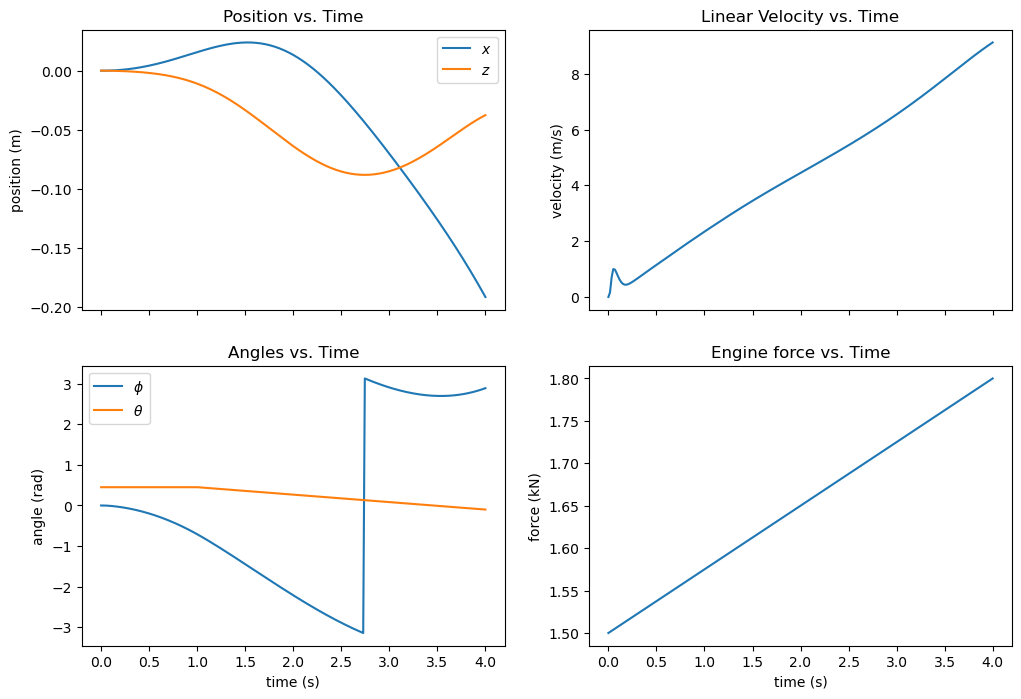

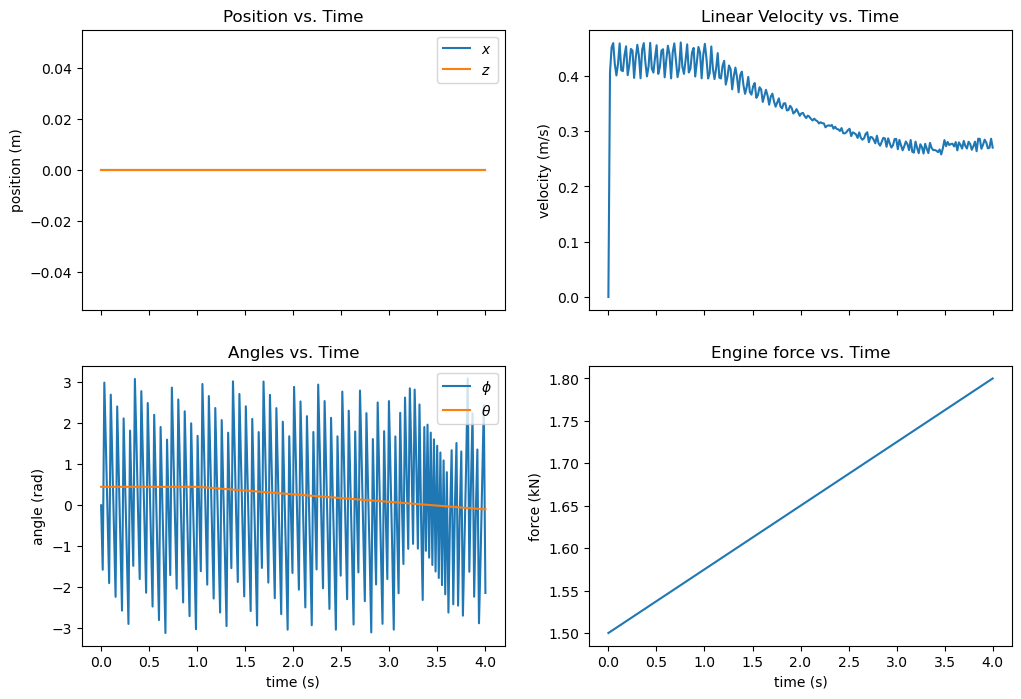

In [17]:
from scipy.integrate import solve_ivp
import control as ctrl

nsteps_test = hz*4
t_test = np.linspace(0, nsteps_test, nsteps_test)
test_inputs = np.array([
    np.linspace(1500, 1800, nsteps_test),
    np.concatenate((
        0.45*np.ones(int(nsteps_test/4)),
        np.linspace(0.45, -0.1, 3*int(nsteps_test/4))
    ))
]).T
test_states = generate_training_data(sim, 0.0, nsteps_test, nstates, test_inputs)

# Now to generate a comparison trajectory
x0 = np.array([0.0, 0.0, 0.0, 1.0, 0.0])
dynamics = extract_sindy_dynamics(model)
# dynamics_sys = ctrl.NonlinearIOSystem(
#     dynamics, None, inputs=["Fe", "theta"], states=["x", "z", "v", "n_x", "n_z"],
#     name="dynamics_sys"
# )
# predicted_states = ctrl.input_output_response(
#     dynamics_sys, T=t_test/hz, U=test_inputs.T, X0=x0
# ).states

predicted_states = np.zeros((nsteps_test, nstates))

for t in range(nsteps_test):
    u = test_inputs[t, :]
    predicted_states[t, :] = x0
    x = dynamics(t, x0, u)
    x0 = np.array(x)

t_test_seconds = t_test/hz

plot_data(t_test_seconds, test_states, test_inputs)
plot_data(t_test_seconds, predicted_states, test_inputs)